# Ejercicio integrador

El objetivo del siguiente ejercicio es aplicar los conocimientos obtenidos sobre los algoritmos más utilizados en aprendizaje supervisado.

Para ello se les brinda un dataset al cual deberán realizar las transformaciones necesarias, definir la variable objetivo, tipo de problema (Regresión/Clasificación) y entrenar un modelo en base al problema.

**Dataset**: `imdb_dataset.csv`

## Importar Librerias

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings("ignore")


# nltk

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer


#TODO sklearn libraries - Completar con el/los modelos predictivos

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

#TODO modelos para comparar
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression, mutual_info_classif
from sklearn import preprocessing, svm







## Carga de datos

In [2]:
df=pd.read_csv('imdb_dataset.csv') #TODO
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data

Para este ejercicio nos limitamos a tomar solo un subset de `10000` instancias.

In [3]:
df_positive = df[df['sentiment']=='positive'][:9000]
df_negative = df[df['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

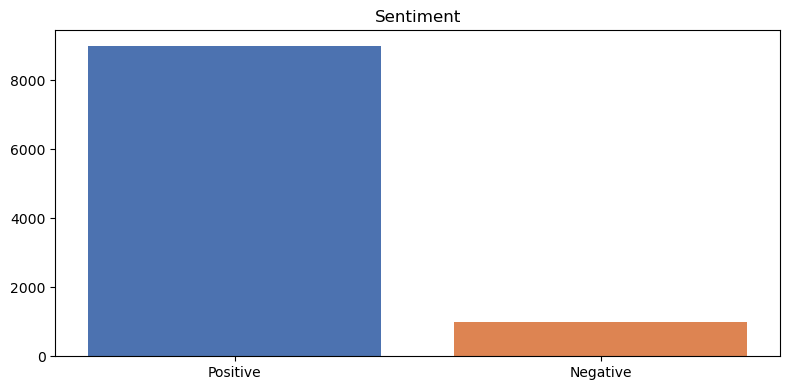

In [4]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.show()

## Preparación y análisis de datos (EDA)

## Resample data

El desequilibrio de datos es un gran problema para las tareas de clasificación. En Python, existe una biblioteca que permite el uso de muchos algoritmos para manejar este estado desequilibrado de los datos y sus daños.

imbalanced-learn es un paquete de Python que ofrece varias técnicas de remuestreo comúnmente utilizadas en conjuntos de datos que muestran un fuerte desequilibrio entre clases. Es compatible con scikit-learn y forma parte de proyectos `scikit-learn`.

Para volver a muestrear nuestros datos utilizamos la biblioteca `imblearn`. Puede submuestrear reseñas positivas o sobremuestrear reseñas negativas (debe elegir según los datos con los que está trabajando). En este caso, usaremos `RandomUnderSampler`

In [5]:
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],
                                                          df_review_imb['sentiment'])


df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


In [6]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
dtype: int64
sentiment
negative    1000
positive    1000
dtype: int64


## Tokenization
La tokenización es una forma de separar un fragmento de texto en unidades más pequeñas llamadas tokens. Aquí, los tokens pueden ser palabras, caracteres o subpalabras. Por lo tanto, la tokenización se puede clasificar en términos generales en 3 tipos: tokenización de palabras, caracteres y subpalabras (caracteres de n-gramas).

Por ejemplo, considere la frase: "Nunca te rindas".

La forma más común de formar tokens se basa en el espacio. Asumiendo el espacio como delimitador, la tokenización de la oración da como resultado 3 tokens: Nunca te rindas. Como cada token es una palabra, se convierte en un ejemplo de tokenización de Word.

In [7]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [8]:
#Funciones para limpieza de datos

def clean_data(text):          #using the re library

    text = text.lower().strip()
    text = re.sub("^a-zA-z0-9\s","", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r"([-?.!,/\"])", r" \1 ", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", "", text)
    text = re.sub(r"[ ]+", " ", text)
    text = text.rstrip().strip()

    return text

In [9]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [10]:
#Apply clean data
df_review_bal['review'] = df_review_bal.review.apply(clean_data)

#Apply function on review column
df_review_bal['review']=df_review_bal['review'].apply(denoise_text)

df_review_bal.head()

,review,sentiment
0,basically theres a family where a little boy j...,negative
1,this show was an amazing fresh & innovative id...,negative
2,encouraged by the positive comments about this...,negative
3,phil the alien is one of those quirky films wh...,negative
4,i saw this movie when i was about 12 when it c...,negative


## Stemming text

La derivación es una técnica que se utiliza para reducir una palabra flexionada hasta la raíz de la palabra. Por ejemplo, las palabras `programación`, `programador` y `programas` se pueden reducir a la raíz común de la palabra `programa`. En otras palabras, `programa` se puede utilizar como sinónimo de las tres palabras de inflexión anteriores.

In [11]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [12]:
#Apply function on review column
df_review_bal['review']=df_review_bal['review'].apply(simple_stemmer)

## Stopwords

`Stopwords` una palabra de parada de uso común (como “el”, “a”, “una”, “en”) que un motor de búsqueda ha sido programado para ignorar, tanto al indexar entradas para la búsqueda como al recuperarlas. como resultado de una consulta de búsqueda.

No queremos que estas palabras ocupen espacio en nuestra base de datos ni que consuman un tiempo de procesamiento valioso. Para ello, podemos eliminarlas fácilmente, almacenando una lista de palabras que consideres vacías.

In [13]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

{'same', 'each', "couldn't", 'wasn', 'when', 'if', 'then', 'too', "shan't", 'that', 'most', 'theirs', "shouldn't", 'so', 'doesn', 'once', 'a', "mustn't", "mightn't", 'or', 'is', 'didn', "needn't", 'ourselves', 'after', 'hers', 'his', 'as', 'now', 'yourselves', 'weren', 'mustn', 'are', 's', 'not', 'than', 'below', 'their', 'who', 'hadn', 'haven', 'in', 'off', "didn't", 'it', 'which', "she's", 'do', 're', "hasn't", "hadn't", 'she', "wasn't", 't', 'out', 'hasn', 'nor', 'be', 'where', 'against', "isn't", 'y', 'my', 'ain', "it's", 'me', 'up', 'themselves', 'can', "should've", 'has', 'these', 'both', 'on', "aren't", 'with', 'they', 'few', 'at', "you've", 'what', 'being', 'from', 'this', 'because', 'were', 'before', 'was', 'i', 'any', 'very', 'o', 'had', 'again', "won't", "don't", 'aren', 'am', 'we', "haven't", "you'll", 'he', 'about', 'ma', 'further', "doesn't", 'you', 'couldn', 'some', 'doing', 'above', 'own', "that'll", 'isn', 'there', 'herself', 'and', 'more', 'through', 'have', 'those', 

In [14]:
#Apply function on review column
df_review_bal['review']=df_review_bal['review'].apply(remove_stopwords)

In [15]:
df_review_bal

,review,sentiment
0,basic famili littl boy jake think zombi hi clo...,negative
1,thi show wa amaz fresh &amp; innov idea 70 fir...,negative
2,encourag posit comment thi film wa look forwar...,negative
3,phil alien one quirki film humour base around ...,negative
4,saw thi movi wa 12 came recal scariest scene w...,negative
...,...,...
1995,knute rockn led extraordinari life hi stori to...,positive
1996,height celebr big brother racism row 2007 invo...,positive
1997,thi anoth robert altman underr filmslet honest...,positive
1998,thi movi special award cann act difficult see ...,positive


## Data split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_review_bal[['review']],df_review_bal['sentiment'],
                                                   test_size= 0.20, random_state= 42 )#TODO


In [17]:
y_train.value_counts()

negative    801
positive    799
Name: sentiment, dtype: int64

## Text Representation (Bag of words)

Los clasificadores y algoritmos de aprendizaje esperan vectores de características numéricas en lugar de documentos de texto sin formato. Es por eso que necesitamos convertir el texto de reseñas de películas en vectores numéricos.

usaremos bolsa de palabras (BOW) ya que nos importa la frecuencia de las palabras en las revisiones de texto; sin embargo, el orden de las palabras es irrelevante. Dos formas comunes de representar una bolsa de palabras son CountVectorizer y Term Frequency, Inverse Document Frequency (TF-IDF).

Queremos identificar palabras únicas/representativas para reseñas positivas y negativas, por lo que elegiremos TF-IDF. Para convertir datos de texto en vectores numéricos con TF-IDF

In [125]:
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(X_train['review'])

# also fit the test_x_vector
test_x_vector = tfidf.transform(X_test['review'])
train_x_vector


<1600x16173 sparse matrix of type '<class 'numpy.float64'>'
	with 145140 stored elements in Compressed Sparse Row format>

In [19]:

train_x_vector[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [20]:
train_x_df = pd.DataFrame(train_x_vector.toarray(), columns=tfidf.get_feature_names_out())
train_x_df


,00,000,007,02,04,08,0clock,0when,10,100,...,zoom,zue,zzzzzzzzzzzzzzzzzz,æon,élan,émigré,être,ísnt,ïn,ünfaith
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Entrenamiento modelo definitivo

In [21]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [71]:
X_training, X_val, y_training, y_val = train_test_split(train_x_df, y_train,
                                                   test_size= 0.20, random_state= 42 )

In [102]:
model_logr = {}
for i in range(1,50,2):
    nombre = f'C{i}'
    model_logr[nombre] = LogisticRegression(C=i)

In [103]:
model_logr

{'C1': LogisticRegression(C=1),
 'C3': LogisticRegression(C=3),
 'C5': LogisticRegression(C=5),
 'C7': LogisticRegression(C=7),
 'C9': LogisticRegression(C=9),
 'C11': LogisticRegression(C=11),
 'C13': LogisticRegression(C=13),
 'C15': LogisticRegression(C=15),
 'C17': LogisticRegression(C=17),
 'C19': LogisticRegression(C=19),
 'C21': LogisticRegression(C=21),
 'C23': LogisticRegression(C=23),
 'C25': LogisticRegression(C=25),
 'C27': LogisticRegression(C=27),
 'C29': LogisticRegression(C=29),
 'C31': LogisticRegression(C=31),
 'C33': LogisticRegression(C=33),
 'C35': LogisticRegression(C=35),
 'C37': LogisticRegression(C=37),
 'C39': LogisticRegression(C=39),
 'C41': LogisticRegression(C=41),
 'C43': LogisticRegression(C=43),
 'C45': LogisticRegression(C=45),
 'C47': LogisticRegression(C=47),
 'C49': LogisticRegression(C=49)}

In [104]:
error_train = model_logr.copy()
error_val = model_logr.copy()

In [105]:
for nombre,modelo in model_logr.items():
    model_logr[nombre].fit(X_training, y_training)
    y_training_pred = model_logr[nombre].predict(X_training)
    y_val_pred = model_logr[nombre].predict(X_val)
    error_train[nombre] = metrics.f1_score(y_training, y_training_pred)
    error_val[nombre] = metrics.f1_score(y_val, y_val_pred)

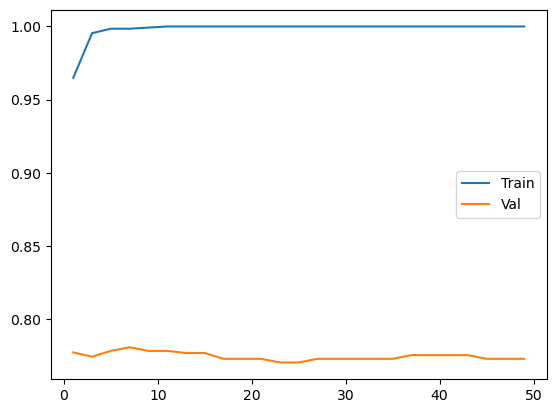

In [106]:
plt.plot(list(range(1,50,2)), error_train.values(), label='Train')
plt.plot(list(range(1,50,2)), error_val.values(), label='Val')
plt.legend()

In [108]:
error_val['C7'], error_val['C9']

(0.7806451612903226, 0.7781350482315113)

In [ ]:
model_arboles = {}
for i in range(1,40,2):
    nombre = f'DT_depth{i}'
    model_arboles[nombre] = DecisionTreeClassifier(max_depth=i)

In [73]:
model_arboles

{'DT_depth1': DecisionTreeClassifier(max_depth=1),
 'DT_depth3': DecisionTreeClassifier(max_depth=3),
 'DT_depth5': DecisionTreeClassifier(max_depth=5),
 'DT_depth7': DecisionTreeClassifier(max_depth=7),
 'DT_depth9': DecisionTreeClassifier(max_depth=9),
 'DT_depth11': DecisionTreeClassifier(max_depth=11),
 'DT_depth13': DecisionTreeClassifier(max_depth=13),
 'DT_depth15': DecisionTreeClassifier(max_depth=15),
 'DT_depth17': DecisionTreeClassifier(max_depth=17),
 'DT_depth19': DecisionTreeClassifier(max_depth=19),
 'DT_depth21': DecisionTreeClassifier(max_depth=21),
 'DT_depth23': DecisionTreeClassifier(max_depth=23),
 'DT_depth25': DecisionTreeClassifier(max_depth=25),
 'DT_depth27': DecisionTreeClassifier(max_depth=27),
 'DT_depth29': DecisionTreeClassifier(max_depth=29),
 'DT_depth31': DecisionTreeClassifier(max_depth=31),
 'DT_depth33': DecisionTreeClassifier(max_depth=33),
 'DT_depth35': DecisionTreeClassifier(max_depth=35),
 'DT_depth37': DecisionTreeClassifier(max_depth=37),
 'D

In [74]:
error_train = model_arboles.copy()
error_val = model_arboles.copy()

In [75]:
for nombre,modelo in model_arboles.items():
    model_arboles[nombre].fit(X_training, y_training)
    y_training_pred = model_arboles[nombre].predict(X_training)
    y_val_pred = model_arboles[nombre].predict(X_val)
    error_train[nombre] = metrics.f1_score(y_training, y_training_pred)
    error_val[nombre] = metrics.f1_score(y_val, y_val_pred)

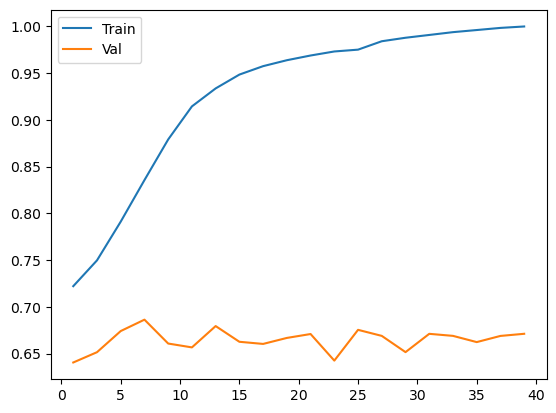

In [76]:
plt.plot(list(range(1,40,2)), error_train.values(), label='Train')
plt.plot(list(range(1,40,2)), error_val.values(), label='Val')
plt.legend()

In [78]:
error_val['DT_depth7'], error_val['DT_depth9']

(0.6862170087976539, 0.6606606606606608)

In [79]:
algoritmos = {'DT' : DecisionTreeClassifier(max_depth=7),
              'LOGR': LogisticRegression()}

In [80]:
# Validacion
y_pred = {}
for nombre,modelo in algoritmos.items():
    y_pred[nombre] = cross_val_predict(modelo, 
                           train_x_df, 
                           y_train, 
                           cv = KFold(n_splits=2, 
                                      shuffle=True, 
                                      random_state=42,
                                     ) , n_jobs=-1) 


In [81]:
y_pred

{'DT': array([1, 0, 0, ..., 0, 1, 1]), 'LOGR': array([0, 0, 0, ..., 0, 1, 1])}

In [82]:
metricas = algoritmos.copy()
for nombre in metricas.keys():
    metricas[nombre] = metrics.accuracy_score(y_train, y_pred[nombre])
    
print(metricas)

{'DT': 0.663125, 'LOGR': 0.79125}


In [42]:
#OTROS ALGORITMOS

algoritmos = {'SVM': svm.SVC(C=10, random_state=42, probability=True),
              'DT' : DecisionTreeClassifier(),
              'LOGR': LogisticRegression()}

In [43]:
# Validacion
y_pred = {}
for nombre,modelo in algoritmos.items():
    y_pred[nombre] = cross_val_predict(modelo, 
                           train_x_df, 
                           y_train, 
                           cv = KFold(n_splits=2, 
                                      shuffle=True, 
                                      random_state=42,
                                     ) , n_jobs=-1) 


In [44]:
y_pred

{'SVM': array([0, 0, 0, ..., 0, 1, 1]),
 'DT': array([0, 0, 0, ..., 1, 1, 1]),
 'LOGR': array([0, 0, 0, ..., 0, 1, 1])}

In [46]:
metricas = algoritmos.copy()
for nombre in metricas.keys():
    metricas[nombre] = metrics.accuracy_score(y_train, y_pred[nombre])
    
print(metricas)

{'SVM': 0.79875, 'DT': 0.68, 'LOGR': 0.79125}


In [122]:
# TODO
model = LogisticRegression(C=7)
model.fit(train_x_df, y_train)

LogisticRegression(C=7)

In [110]:
# Testeamos el modelo
print(model.predict(tfidf.transform(['A good movie'])))
print(model.predict(tfidf.transform(['An excellent movie'])))
print(model.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

[1]
[1]
[0]


In [111]:
# TODO
model = DecisionTreeClassifier(max_depth=7)
model.fit(train_x_df, y_train)

DecisionTreeClassifier(max_depth=7)

In [112]:
# Testeamos el modelo
print(model.predict(tfidf.transform(['A good movie'])))
print(model.predict(tfidf.transform(['An excellent movie'])))
print(model.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

[1]
[1]
[1]


In [115]:
# TODO
model = svm.SVC(C=10, random_state=42, probability=True)
model.fit(train_x_df, y_train)

SVC(C=10, probability=True, random_state=42)

In [118]:
# Testeamos el modelo
print(model.predict(tfidf.transform(['A good movie']).toarray()))
print(model.predict(tfidf.transform(['An excellent movie']).toarray()))
print(model.predict(tfidf.transform(['I did not like this movie at all I gave this movie away']).toarray()))

[1]
[1]
[0]


In [119]:
print(model.predict(tfidf.transform(['This was a bad movie']).toarray()))

[0]


## Evaluación modelo

In [127]:
print(model.score(test_x_vector, y_test))
print(model.score(test_x_vector, y_test))
print(model.score(test_x_vector, y_test))

0.8525
0.8525
0.8525


In [130]:
# Nos quedamos con el mejor modelo y obtenemos sus métricas

y_pred_test = model.predict(test_x_vector)
print(y_pred_test)

[1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1
 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1
 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0
 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1
 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0
 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0]


In [131]:
# 10) Evaluación del modelo sobre el conjunto de test
print(metrics.confusion_matrix(y_test, y_pred_test))

[[165  34]
 [ 25 176]]
